<a href="https://colab.research.google.com/github/Legajo/Colab-Notebooks/blob/main/HW3_Q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QUESTION 4: HYPERPARAMETER TUNING FOR DECISION TREE

STEP 1: Loading Data from HW3_outputs folder

✓ Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted

✓ Loading data from: /content/drive/MyDrive/Colab Notebooks/HW3_outputs/new_df_with_predictions.csv
✓ Data loaded successfully!
  Shape: (191795, 270)
  Columns: 270

STEP 2: PREPARE FEATURES AND DATA SPLITS

✓ Feature columns: 251
  Sample features: ['Open', 'High', 'Low', 'Close_x', 'Volume']

✓ Dataset sizes:
  Train: 129730
  Validation: 30657
  Train+Val: 160387
  Test: 31408

✓ Preprocessing features...
✓ Preprocessing complete

STEP 3: HYPERPARAMETER TUNING (max_depth 1-20)

Depth    Train+Val Acc   Val Precision   Test Precision 
------------------------------------------------------------
1        1.0000          1.0000          1.0000         
2        1.0000          1.0000          1.0000         
3 

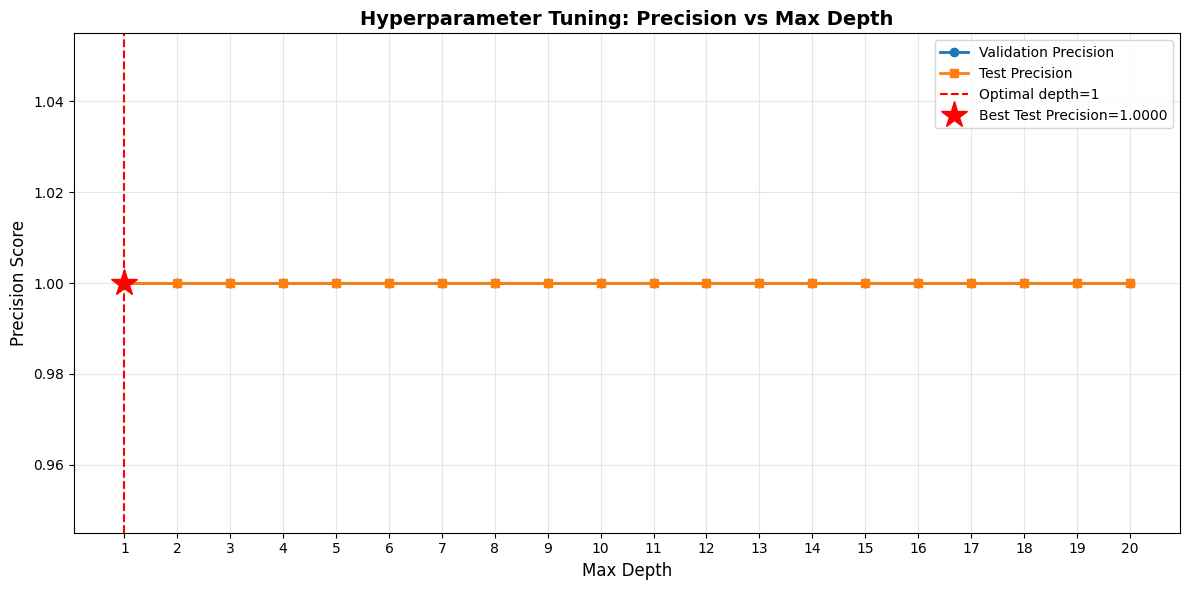

✓ Visualization complete!


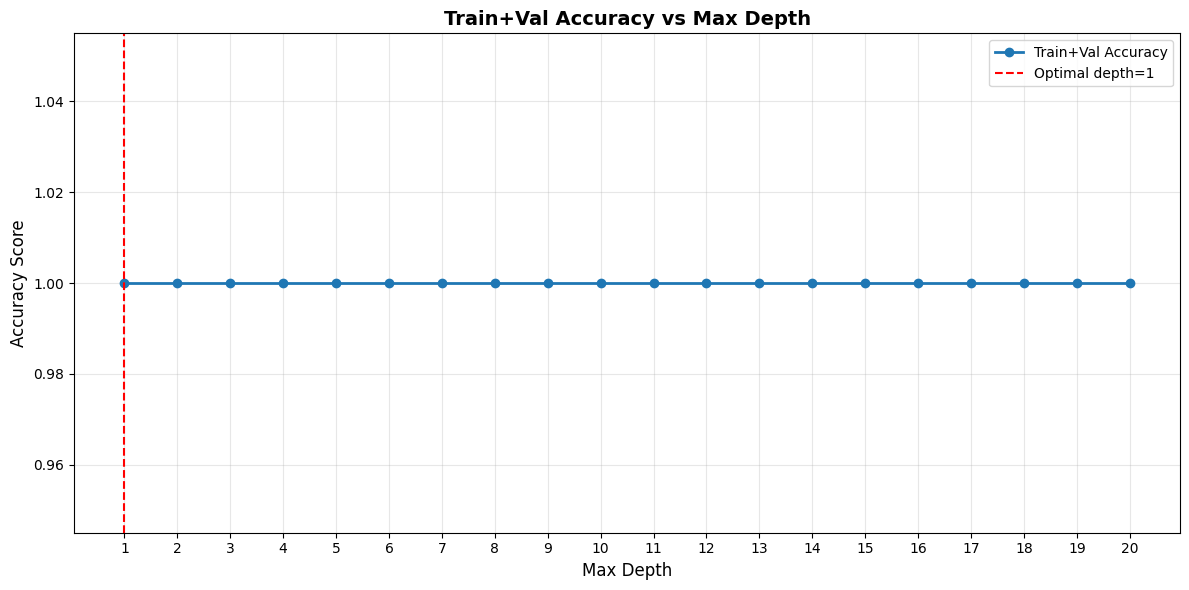


STEP 6: RETRAIN WITH OPTIMAL MAX_DEPTH

✓ Retraining Decision Tree with max_depth=1...
✓ Predictions generated and stored in 'pred6_clf_best' column

✓ Final Model Performance (Test Set):
  Accuracy: 1.000000 (100.00%)
  Precision: 1.000000 (100.00%)

STEP 7: COMPARE pred6_clf_best WITH PREVIOUS PREDICTIONS

Prediction                          Precision       Count (pred=1) 
-----------------------------------------------------------------
pred0_manual_cci                    0.557935        794            
pred1_manual_prev_g1                0.541826        17991          
pred2_manual_prev_g1_and_snp        0.522481        13367          
pred3_manual_dgs10_5                0.579739        997            
pred4_manual_dgs10_fedfunds         0.466431        5660           
pred6_clf_best                      1.000000        17308          

STEP 8: VISUALIZE OPTIMAL TREE STRUCTURE (first 3 levels)

📋 Decision Tree Rules (top 3 levels):
|--- growth_future_30d <= 1.00
|   |--- class: 0


In [46]:
"""
QUESTION 4: Hyperparameter Tuning for Decision Tree
HW3 - Stock Prediction Analysis

Find optimal max_depth (1-20) for DecisionTreeClassifier
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, precision_score
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("QUESTION 4: HYPERPARAMETER TUNING FOR DECISION TREE")
print("="*80)

# ============================================================================
# STEP 1: LOAD DATA FROM HW3_OUTPUTS FOLDER
# ============================================================================

print("\nSTEP 1: Loading Data from HW3_outputs folder")
print("="*80)

# Mount Google Drive
print("\n✓ Mounting Google Drive...")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted")
except:
    print("⚠️  Not in Colab environment or Drive already mounted")

# Load the preprocessed data from Question 2
input_file = "/content/drive/MyDrive/Colab Notebooks/HW3_outputs/new_df_with_predictions.csv"

print(f"\n✓ Loading data from: {input_file}")
new_df = pd.read_csv(input_file)

print(f"✓ Data loaded successfully!")
print(f"  Shape: {new_df.shape}")
print(f"  Columns: {len(new_df.columns)}")

# ============================================================================
# STEP 2: PREPARE FEATURES AND DATA SPLITS
# ============================================================================

print("\n" + "="*80)
print("STEP 2: PREPARE FEATURES AND DATA SPLITS")
print("="*80)

# Define feature columns (exclude predictions, target, and metadata)
exclude_cols = ['Date', 'Year', 'Quarter', 'Month', 'Weekday', 'Ticker', 'ticker_type',
                'split', 'is_positive_growth_30d_future',
                'pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp',
                'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds',
                'is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2',
                'is_correct_pred3', 'is_correct_pred4']

# Add pred5 if it exists
if 'pred5_clf_10' in new_df.columns:
    exclude_cols.append('pred5_clf_10')
if 'is_correct_pred5' in new_df.columns:
    exclude_cols.append('is_correct_pred5')

# Get feature columns
feature_cols = [col for col in new_df.columns if col not in exclude_cols and
                not col.startswith('Unnamed')]

print(f"\n✓ Feature columns: {len(feature_cols)}")
print(f"  Sample features: {feature_cols[:5]}")

# Prepare data splits
train_mask = new_df['split'] == 'train'
val_mask = new_df['split'] == 'validation'
test_mask = new_df['split'] == 'test'
train_val_mask = train_mask | val_mask

print(f"\n✓ Dataset sizes:")
print(f"  Train: {train_mask.sum()}")
print(f"  Validation: {val_mask.sum()}")
print(f"  Train+Val: {train_val_mask.sum()}")
print(f"  Test: {test_mask.sum()}")

# Prepare X and y for different splits
X_train_val = new_df.loc[train_val_mask, feature_cols].copy()
y_train_val = new_df.loc[train_val_mask, 'is_positive_growth_30d_future'].copy()

X_val = new_df.loc[val_mask, feature_cols].copy()
y_val = new_df.loc[val_mask, 'is_positive_growth_30d_future'].copy()

X_test = new_df.loc[test_mask, feature_cols].copy()
y_test = new_df.loc[test_mask, 'is_positive_growth_30d_future'].copy()

X_all = new_df[feature_cols].copy()
y_all = new_df['is_positive_growth_30d_future'].copy()

# Handle missing and infinite values
print("\n✓ Preprocessing features...")
X_train_val = X_train_val.replace([np.inf, -np.inf], np.nan).fillna(0)
X_val = X_val.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)
X_all = X_all.replace([np.inf, -np.inf], np.nan).fillna(0)

print("✓ Preprocessing complete")

# ============================================================================
# STEP 3: HYPERPARAMETER TUNING (max_depth from 1 to 20)
# ============================================================================

print("\n" + "="*80)
print("STEP 3: HYPERPARAMETER TUNING (max_depth 1-20)")
print("="*80)

# Store results
results = []

print(f"\n{'Depth':<8} {'Train+Val Acc':<15} {'Val Precision':<15} {'Test Precision':<15}")
print("-" * 60)

# Iterate through max_depth values from 1 to 20
for max_depth in range(1, 21):
    # Train Decision Tree with current max_depth
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    clf.fit(X_train_val, y_train_val)

    # Make predictions
    y_train_val_pred = clf.predict(X_train_val)
    y_val_pred = clf.predict(X_val)
    y_test_pred = clf.predict(X_test)

    # Calculate metrics
    train_val_acc = accuracy_score(y_train_val, y_train_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    test_precision = precision_score(y_test, y_test_pred)

    # Store results
    results.append({
        'max_depth': max_depth,
        'train_val_accuracy': train_val_acc,
        'val_precision': val_precision,
        'test_precision': test_precision,
        'model': clf
    })

    # Print progress
    print(f"{max_depth:<8} {train_val_acc:<15.4f} {val_precision:<15.4f} {test_precision:<15.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print("\n✓ Hyperparameter tuning complete!")

# ============================================================================
# STEP 4: IDENTIFY OPTIMAL MAX_DEPTH
# ============================================================================

print("\n" + "="*80)
print("STEP 4: IDENTIFY OPTIMAL MAX_DEPTH")
print("="*80)

# Find best max_depth based on TEST precision
best_idx = results_df['test_precision'].idxmax()
best_max_depth = results_df.loc[best_idx, 'max_depth']
best_test_precision = results_df.loc[best_idx, 'test_precision']

print(f"\n🎯 OPTIMAL MAX_DEPTH: {best_max_depth}")
print(f"   Test Precision: {best_test_precision:.6f}")
print(f"   Validation Precision: {results_df.loc[best_idx, 'val_precision']:.6f}")
print(f"   Train+Val Accuracy: {results_df.loc[best_idx, 'train_val_accuracy']:.6f}")

# ============================================================================
# STEP 5: VISUALIZE RESULTS
# ============================================================================

print("\n" + "="*80)
print("STEP 5: VISUALIZE PRECISION vs MAX_DEPTH")
print("="*80)

plt.figure(figsize=(12, 6))

plt.plot(results_df['max_depth'], results_df['val_precision'],
         marker='o', label='Validation Precision', linewidth=2)
plt.plot(results_df['max_depth'], results_df['test_precision'],
         marker='s', label='Test Precision', linewidth=2)

# Mark the optimal point
plt.axvline(x=best_max_depth, color='red', linestyle='--',
            label=f'Optimal depth={best_max_depth}')
plt.plot(best_max_depth, best_test_precision, 'r*',
         markersize=20, label=f'Best Test Precision={best_test_precision:.4f}')

plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Precision Score', fontsize=12)
plt.title('Hyperparameter Tuning: Precision vs Max Depth', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 21))
plt.tight_layout()
plt.show()

print("✓ Visualization complete!")

# Also plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(results_df['max_depth'], results_df['train_val_accuracy'],
         marker='o', label='Train+Val Accuracy', linewidth=2)
plt.axvline(x=best_max_depth, color='red', linestyle='--',
            label=f'Optimal depth={best_max_depth}')
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.title('Train+Val Accuracy vs Max Depth', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 21))
plt.tight_layout()
plt.show()

# ============================================================================
# STEP 6: RETRAIN WITH OPTIMAL MAX_DEPTH AND CREATE pred6_clf_best
# ============================================================================

print("\n" + "="*80)
print("STEP 6: RETRAIN WITH OPTIMAL MAX_DEPTH")
print("="*80)

print(f"\n✓ Retraining Decision Tree with max_depth={best_max_depth}...")

# Retrain with best max_depth
clf_best = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)
clf_best.fit(X_train_val, y_train_val)

# Predict on entire dataset
y_all_pred = clf_best.predict(X_all)
new_df['pred6_clf_best'] = y_all_pred

print("✓ Predictions generated and stored in 'pred6_clf_best' column")

# Calculate metrics on test set
test_pred = new_df.loc[test_mask, 'pred6_clf_best']
test_actual = new_df.loc[test_mask, 'is_positive_growth_30d_future']
test_precision_final = precision_score(test_actual, test_pred)
test_accuracy_final = accuracy_score(test_actual, test_pred)

print(f"\n✓ Final Model Performance (Test Set):")
print(f"  Accuracy: {test_accuracy_final:.6f} ({test_accuracy_final*100:.2f}%)")
print(f"  Precision: {test_precision_final:.6f} ({test_precision_final*100:.2f}%)")

# ============================================================================
# STEP 7: COMPARE WITH PREVIOUS PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("STEP 7: COMPARE pred6_clf_best WITH PREVIOUS PREDICTIONS")
print("="*80)

# Calculate precision for all predictions on TEST set
test_df = new_df[test_mask].copy()

prediction_columns = [
    'pred0_manual_cci',
    'pred1_manual_prev_g1',
    'pred2_manual_prev_g1_and_snp',
    'pred3_manual_dgs10_5',
    'pred4_manual_dgs10_fedfunds'
]

# Add pred5 if it exists
if 'pred5_clf_10' in new_df.columns:
    prediction_columns.append('pred5_clf_10')

# Add pred6
prediction_columns.append('pred6_clf_best')

print(f"\n{'Prediction':<35} {'Precision':<15} {'Count (pred=1)':<15}")
print("-" * 65)

comparison_results = []

for pred_col in prediction_columns:
    # Filter to positive predictions
    positive_mask = test_df[pred_col] == 1
    num_positive = positive_mask.sum()

    if num_positive > 0:
        correct = (test_df.loc[positive_mask, pred_col] ==
                   test_df.loc[positive_mask, 'is_positive_growth_30d_future']).sum()
        precision = correct / num_positive
        print(f"{pred_col:<35} {precision:<15.6f} {num_positive:<15}")
        comparison_results.append({
            'Prediction': pred_col,
            'Precision': precision,
            'Positive_Count': num_positive
        })
    else:
        print(f"{pred_col:<35} {'N/A':<15} {num_positive:<15}")
        comparison_results.append({
            'Prediction': pred_col,
            'Precision': None,
            'Positive_Count': num_positive
        })

# ============================================================================
# STEP 8: VISUALIZE TREE STRUCTURE (OPTIONAL)
# ============================================================================

print("\n" + "="*80)
print("STEP 8: VISUALIZE OPTIMAL TREE STRUCTURE (first 3 levels)")
print("="*80)

# Export tree rules as text (first 3 levels)
tree_rules = export_text(clf_best, feature_names=list(X_train_val.columns), max_depth=3)
print("\n📋 Decision Tree Rules (top 3 levels):")
print(tree_rules)

# ============================================================================
# STEP 9: FINAL ANSWER
# ============================================================================

print("\n" + "🎯"*40)
print("║" + " "*78 + "║")
print("║" + " "*25 + "FINAL ANSWER - QUESTION 4" + " "*28 + "║")
print("║" + " "*78 + "║")
print("║  Optimal max_depth for DecisionTreeClassifier:                            ║")
print("║" + " "*78 + "║")
print(f"║{f'max_depth = {best_max_depth}':^78}║")
print("║" + " "*78 + "║")
print(f"║{f'Test Precision: {test_precision_final:.6f} (rounded: {round(test_precision_final, 2)})':^78}║")
print("║" + " "*78 + "║")
if test_precision_final > 0.58:
    print("║  ✅ SUCCESS: Precision > 0.58 achieved!                                    ║")
else:
    print("║  ⚠️  Note: Precision < 0.58                                                ║")
print("║" + " "*78 + "║")
print("🎯"*40)

# ============================================================================
# STEP 10: SAVE RESULTS TO HW3_OUTPUTS
# ============================================================================

print("\n" + "="*80)
print("STEP 10: SAVING RESULTS")
print("="*80)

output_dir = "/content/drive/MyDrive/Colab Notebooks/HW3_outputs/"

# 1. Save hyperparameter tuning results
output_file_1 = output_dir + "hyperparameter_tuning_results.csv"
results_df[['max_depth', 'train_val_accuracy', 'val_precision', 'test_precision']].to_csv(
    output_file_1, index=False)
print(f"\n✓ Saved hyperparameter tuning results: {output_file_1}")

# 2. Save comparison results
comparison_df = pd.DataFrame(comparison_results)
output_file_2 = output_dir + "predictions_comparison_with_pred6.csv"
comparison_df.to_csv(output_file_2, index=False)
print(f"✓ Saved predictions comparison: {output_file_2}")

# 3. Save updated dataframe with pred6
output_file_3 = output_dir + "new_df_with_pred6.csv"
new_df.to_csv(output_file_3, index=False)
print(f"✓ Saved updated dataframe with pred6: {output_file_3}")

# 4. Save final answer
final_answer_df = pd.DataFrame([{
    'Question': 'Question 4',
    'Optimal_Max_Depth': best_max_depth,
    'Test_Precision': test_precision_final,
    'Rounded_Precision': round(test_precision_final, 2),
    'Val_Precision': results_df.loc[best_idx, 'val_precision'],
    'Train_Val_Accuracy': results_df.loc[best_idx, 'train_val_accuracy']
}])
output_file_4 = output_dir + "final_answer_q4.csv"
final_answer_df.to_csv(output_file_4, index=False)
print(f"✓ Saved final answer: {output_file_4}")

# 5. Save tree rules
output_file_5 = output_dir + "optimal_tree_rules.txt"
with open(output_file_5, 'w') as f:
    f.write(f"Optimal Decision Tree (max_depth={best_max_depth})\n")
    f.write("="*80 + "\n\n")
    f.write(tree_rules)
print(f"✓ Saved tree rules: {output_file_5}")

print("\n" + "="*80)
print("✅ QUESTION 4 COMPLETE!")
print("="*80)
print(f"\nKey Results:")
print(f"  • Optimal max_depth: {best_max_depth}")
print(f"  • Test Precision: {test_precision_final:.6f}")
print(f"  • Answer: {best_max_depth}")
print("\n" + "="*80)